In [22]:
# Imports
import keras 
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import os
import numpy as np

 Goal:

- Build a Encoder - Decoder Model with attention LSTM (little brother of the transformers)

Roadmap:

- Tokenizer: Inputs the text tokenizes it to token IDs like [152323,11]
-  Embedding Layer: Takes the token Ids and maps them to vectors

In [23]:
# Dataset Preparation


input_texts = []
output_texts = []


code_path = os.path.join("Dataset","Code")
prompt_path = os.path.join("Dataset","prompts")


# Dataset Paths


prompt_files = sorted(os.listdir(prompt_path))  
code_files = sorted(os.listdir(code_path))


# Sorts all files correctly to match like 0.txt , 1.txt, 2.txt

for p_file, c_file in zip(prompt_files,code_files):
  with open(os.path.join(prompt_path,p_file)) as f:
    prompt_text = f.read().strip()
    input_texts.append(prompt_text)
  with open(os.path.join(code_path,c_file)) as f:
    code_text = f.read().strip()
    output_texts.append(code_text)


# Open each file and reads the Content
print(input_texts)
print(output_texts)


# Appends the content to the Dataset Arrays



['button,  red-500,  rounded, label: Submit', 'button,  bg-blue-500,  rounded shadow-lg, label: Submit', 'button,  bg-purple-500,  rounded rounded-full shadow-xl, label: PURCHASE', 'button,  bg-blue-500,  rounded rounded-full shadow-lg, label: Submit', 'button,  bg-blue-500 hover:bg-darkblue-600,  rounded-lg shadow-md focus:ring-blue-300, label: Click Me', 'button,  red-500,  rounded-full shadow-none, label: Submit', 'button,  bg-blue-500 hover:bg-purple-600,  rounded, label: Click Me', 'button,  bg-blue-500,  rounded-lg shadow-md, label: Submit', 'button,  bg-blue-500,  rounded border shadow, label: Submit', 'button,  bg-purple-500,  rounded border-2xl shadow-md hover:bg-purple-600 focus:outline-indigo, label: Click Me', 'button,  bg-indigo-500 hover:bg-purple-600 focus:bg-blue-400,  rounded border-2xl px-3 py-2.5 text-lg font-bold underline cursor-pointer transition duration-150ms ease-in-out shadow hover:-translateY-2 sm:shadow md:shadow lg:shadow xl:shadow, label: Submit', 'button,

In [24]:
# Tokenizer

input_tokenizer = Tokenizer(num_words= 10000, oov_token="<OOV>")
output_tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")


# So the Tokenizer converts words to a Token ID
# We have two Tokenizers one for Input taking the Prompt in this Case: "Button, blue-500, round, "Click me" "
# And we have one for Outputing the Answer of the Model in this case <Button classname="" ... > and so on
# num words is the ammount of the Top words we keep for the Tokenizer


input_tokenizer.fit_on_texts(texts=input_texts)
output_tokenizer.fit_on_texts(["<Start> " + t + "<End>" for t in output_texts])

# Training the Tokenizer on the vocab and adding Start and End Tokens

encoder_sequences = input_tokenizer.texts_to_sequences(input_texts)
decoder_sequences = output_tokenizer.texts_to_sequences(["<Start> " + t + "<End>" for t in output_texts])


# So the text_to_sequences is therefore to convert each word or also called Token to its corresponding ID
# In this Case we first train the Tokenizers to generate IDs, and than we let the Tokenizers generate IDs

max_encoder_len = max(len(seq) for seq in encoder_sequences)
max_decoder_len = max(len(seq) for seq in decoder_sequences)

# These are the neccessary lengths so we can pad all sequences in a batch to have the same size this process is calling padding 
# So we get the max length and afterwards check if the length of sequence is long enough else we add zero's till the max_encoder / max_decoder length is reached

encoder_sequences = pad_sequences(encoder_sequences,maxlen=max_encoder_len,padding='post')
decoder_sequences = pad_sequences(decoder_sequences,maxlen=max_decoder_len,padding='post')

# Padding Done which means all Sequences have the same length now and can be fed to the model

decoder_input = decoder_sequences[:,:-1] 
decoder_target = decoder_sequences[:,1:]

# Decoder Input is the input we fed to the Decoder during Training (<Start> + tokens)
# And the Decoder Output is the target the Model should predict (tokens + <End>)


In [ ]:
# LSTM model no attention

embed_dim = 128  
lstm_units = 256
# Memory Cells

input_vocab_size = len(input_tokenizer.word_index) +1
output_vocab_size = len(output_tokenizer.word_index) +1


# embed_dim is the size of word embeddings
# lstm_units is the number of Long short term memory hidden units
# and vocab sizes


encoder_inputs = keras.Input(shape=(None,))  

# Input is a Sequence of word IDs

x = layers.Embedding(input_vocab_size,embed_dim)(encoder_inputs)
# Vectors are nececssary for building semantic

enocder_outputs, state_h, state_c = layers.LSTM(lstm_units,return_state=True)(x)
encoder_states = [state_h, state_c]

# state_h = short term memroy current summary at the last timestep
# state_c = cell state = long term == what the LSTM remembers
# Embedding Layer transforms Token IDs to vectors
# Encoder_states are states so the decoder knows about what the encoder talked about
# LSTM Layers reads the sequence step by step -> returning states that contain all the neccessary information for the Decoder


decoder_inputs = keras.Input(shape=(None,))


y = layers.Embedding(output_vocab_size, embed_dim)(decoder_inputs)
decoder_lstm = layers.LSTM(lstm_units, return_sequences=True,return_state=True)
decoder_outputs, _, _= decoder_lstm(y,initial_state=encoder_states)
decoder_dense = layers.Dense(output_vocab_size,activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)


# Embedding Layer transforms Token IDs to vectors
# Now the LSTM layer reads the sequence and starts with the inital states provided by the encoder
# Than in the Dense Layer it predicts the words of the vocab with the most probability

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)



In [26]:
# Model Training and Compiling


model.compile(
  optimizer="adam",
  loss="sparse_categorical_crossentropy",
  metrics=["accuracy"]
)

# Compile the Model with Adam as optimizer and use the accuracy for training metric


batch_size = 32
epochs = 50


earlyStopping = keras.callbacks.EarlyStopping(
  monitor="val_loss",
  patience=5,
  restore_best_weights=True
)


history = model.fit(
    [encoder_sequences, decoder_input],
    decoder_target,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    verbose=1,
    callbacks=[earlyStopping]
)

encoder_model = keras.Model(encoder_inputs,encoder_states)

decoder_state_input_h = keras.Input(shape=(lstm_units,))
decoder_state_input_c = keras.Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedded = layers.Embedding(output_vocab_size, embed_dim)(decoder_inputs)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(decoder_embedded, initial_state=decoder_states_inputs)
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)
decoder_states_inf = [state_h_inf, state_c_inf]

decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs_inf] + decoder_states_inf
)

encoder_model.save("encoder.keras") 
decoder_model.save("decoder.keras")


model.save("ShadAI.keras")

Epoch 1/50
3/3 [==============================] - 3s 351ms/step - loss: 4.5809 - accuracy: 0.4379 - val_loss: 4.3821 - val_accuracy: 0.6379
Epoch 2/50
3/3 [==============================] - 0s 40ms/step - loss: 4.0548 - accuracy: 0.6756 - val_loss: 2.4411 - val_accuracy: 0.6379
Epoch 3/50
3/3 [==============================] - 0s 43ms/step - loss: 2.0065 - accuracy: 0.6754 - val_loss: 2.3003 - val_accuracy: 0.6379
Epoch 4/50
3/3 [==============================] - 0s 49ms/step - loss: 1.8245 - accuracy: 0.6753 - val_loss: 2.0266 - val_accuracy: 0.6485
Epoch 5/50
3/3 [==============================] - 0s 39ms/step - loss: 1.7475 - accuracy: 0.6796 - val_loss: 1.9867 - val_accuracy: 0.6379
Epoch 6/50
3/3 [==============================] - 0s 36ms/step - loss: 1.6773 - accuracy: 0.6754 - val_loss: 1.8615 - val_accuracy: 0.6379
Epoch 7/50
3/3 [==============================] - 0s 32ms/step - loss: 1.6295 - accuracy: 0.6754 - val_loss: 1.8083 - val_accuracy: 0.6485
Epoch 8/50
3/3 [==========

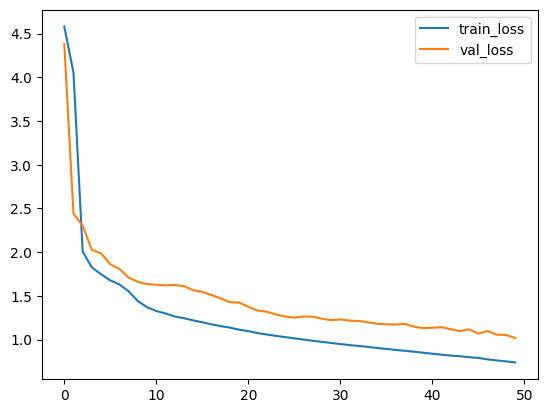

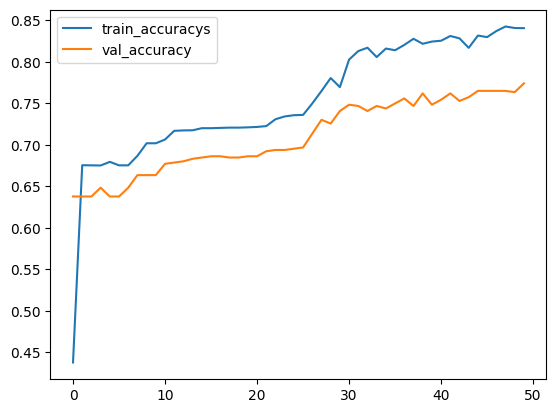

In [27]:
# Data Showcase

import matplotlib.pyplot as plt

# Showcasing Loss to validation loss
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Showcasing accuracy to validation accuracy
plt.plot(history.history['accuracy'], label="train_accuracys")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()



In [28]:
# Inference
from keras import models
from keras import layers
import keras

encoder_model = keras.models.load_model("encoder.keras")
decoder_model = keras.models.load_model("decoder.keras")
# Rebuilding the Model

# Next Step decoding input sequence and letting the model do the magic
# Check what tokens are actually there



prompt ="button,  bg-blue-500,  rounded-lg shadow-md hover:shadow-xl transition-all duration-300 ease-in-out, label: Click me"

input_seq = input_tokenizer.texts_to_sequences([prompt])
input_seq = pad_sequences(input_seq,maxlen=max_encoder_len,padding='post')

target_seq = np.array([[output_tokenizer.word_index["start"]]])
states_values = encoder_model.predict(input_seq)

decoded_sequence = ""
stop_condition = False

while not stop_condition:
    output_tokens, h,c = decoder_model.predict([target_seq] + states_values)
    sample_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_word = output_tokenizer.index_word.get(sample_token_index,"")
    if sampled_word == "end" or len(decoded_sequence.split()) > 50:
        stop_condition = True
    
    decoded_sequence += " " + sampled_word

   
    states_values = [h,c]
    target_seq = np.array([[sample_token_index]])

print(decoded_sequence)




1/1 [==============================] - 0s 19ms/step
 button classname bg blue 500 hover bg bg 700 text font bold py 2 px  end


Summary:

- Encoder processes the input sequenc and creates states

- Decoder starts processing with inital States from the Encoder
 -> outputs Predictions for each Target Token



# How The Model Works (how seq2seq works)

- Brief Overview before Deep Dive

-> encoder reads the input sequence and summarizes it into internal states state_h and state_c this is basically the Context for the Decoder Model,
the decoders generates the output sequence step by step word for word by using the encoders States (summary)

# Step 1
- Computers ONLY understand Numbers thats why we need Tokenization
- So heres how it works:

-> The Tokenizers Goal is to convert Words or symbols into Integer IDs

Example: 

Input: "button, blue, round"
Tokenized: [15, 2, 8]

- we Train two Tokenizers first the Input Tokenizer his Goal is to understand the Vocab of the Dataset in this case prompts next we train the Output Tokenizer on the Code of the Dataset to 
fit him on the Vocabulary

# Step 2
- LSTMs want to have batches of the same Shape, for this case it means it doesnt want to have sequences with different lengths so it uses a Method called Padding,
padding just adds 0 to the Sequence to match the required length

- we generate the Sequences with our Tokenizer and we use Padding to make all sequences the Same length

